# Final assignment: CO2 emissions
This analysis focuses on the following questions:

1.   What is the biggest predictor of a large CO2 output per capita of a country?
2.   Which countries are making the biggest strides in decreasing CO2 output?
3. Which non-fossil fuel energy technology will have the best price in the future?



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%load_ext google.colab.data_table

In [2]:
from scipy.stats import pearsonr
from sklearn.metrics import r2_score

Definitions used in this notebook:

In [4]:
def read_and_merge(df_name: str, url: str):
  df_name = pd.read_csv(url)
  df_name.drop(columns = "Code", inplace=True)
  return pd.merge(df, df_name, how = 'left', on=['Entity','Year'])

In [5]:
def print_separator(sep, num, msg):
  print("\n")
  print(sep * num)
  print(f"{msg}")
  print(sep * num)


def look_at_unique_values(column):
  unique_values_cutoff = 200
  unique_values = column.unique()
  num_unique_values = len(unique_values)
  if num_unique_values == len(column):
    print(f"Each value in the column is unique (total: {num_unique_values})")
  elif num_unique_values < unique_values_cutoff:
    print(f"Less than {unique_values_cutoff} unique values:")
    # We may get an error when sorting
    try:
      sorted_values = sorted(unique_values)
      print("Values are sorted")
      display((sorted_values))
    except:
      print("Could not sort values")
      display(list(unique_values))
  else:
    print(f"More than {unique_values_cutoff} unique values (total: {num_unique_values})")


def look_at_edges(df, column_name):
  def show_head_and_tail(values):
      num_items_to_slice = 10
      display(list(values)[:num_items_to_slice])
      display(list(values)[-num_items_to_slice:])

  column = df[column_name]
  unique_values = column.unique()
  try:
      sorted = np.sort(unique_values)
      print("Unique values sorted, head and tail:")
      show_head_and_tail(sorted)
  except TypeError as error:
      try:
        print(f"Could not sort values because of: {error}")
        print("..so let's try filtering NULL values and then sorting")
        non_null_uniques = df.loc[~column.isnull(), column_name].unique()
        sorted = np.sort(non_null_uniques)
        show_head_and_tail(sorted)
      except TypeError as error:
        print(f"Could not sort values because of: {error}")


def cast_to_type(column, maybe_type):
  try:
    column.astype(maybe_type)
    print(f"Casting to {maybe_type} was successful")
  except ValueError as error:
    print(f"Could not cast to {maybe_type}: {error}")


def find_non_default_missing_values(df, column_name, maybe_type):
  long_separator_amount = 80
  short_separator_amount = 40

  print_separator("*", long_separator_amount, f"Finding non default missing values for column \"{column_name}\"")

  print(f"Column \"{column_name}\" has datatype: {df.dtypes[column_name]}")

  column = df[column_name]

  # A
  print_separator("-", short_separator_amount, "A: Looking at unique values")
  look_at_unique_values(column)

  # B
  print_separator("-", short_separator_amount, "B: Sorting and looking at the edges")
  look_at_edges(df, column_name)

  # C
  print_separator("-", short_separator_amount, f"C: Casting to type: {maybe_type}")
  cast_to_type(column, maybe_type)

  # D
  print_separator("-", short_separator_amount, "D: Looking at frequency")
  display(column.value_counts(dropna=False))

  print("\n")

def replace_value(df, column_name, old, new):
  df[column_name] = df[column_name].replace({old: new})

In [6]:
def correlation(df, column1: str, column2: str):
  corr_coefficient, p_value = pearsonr(df[column1], df[column2])
  print(f'Correlation between {column1} and {column2}:\ncorrelation coefficient: ', corr_coefficient, '\np-value:', p_value)

In [7]:
def create_scatterplot(ax, df, column1: str, column2: str, title: str, x_label: str, pos1: float = 0, pos2: float = 0, y_lim: float = 70, x_lim: float = 100, y_label: str = 'Annual CO2 emission per capita'):
  df_scatter = df.dropna(subset=[column1, column2])
  ax.scatter(df_scatter[column1], df_scatter[column2], c='b')
  ax.grid(linestyle='--')
  ax.set_xlabel(x_label)
  ax.set_ylabel(y_label)
  ax.set_title(title)
  ax.set_xlim(0, x_lim)
  ax.set_ylim(0, y_lim)
  m, b = np.polyfit(df_scatter[column1], df_scatter[column2], deg=1)
  ax.plot(df_scatter[column1], m*df_scatter[column1]+b, c='k')
  corr_coefficient, p_value = pearsonr(df_scatter[column1], df_scatter[column2])
  equation = f"y = {m:.4f}x + {b:.2f}"
  ax.text(pos1,pos2, f'{equation}\ncorr coef={corr_coefficient.round(2)}   p={p_value.round(5)}', fontsize=10, va='center', bbox=dict(boxstyle="round", ec=(1., 0.5, 0.5), fc=(1., 0.8, 0.8)))

In [8]:
def plot_linear_regression(column, color, label: str, df, start: str = 1985, stop: str = 2041):
   ax.plot(df.index, df[column], marker='.', linestyle='dotted', c=color)
   df_regression = df.dropna(subset=column)
   m, b = np.polyfit(df_regression.index, df_regression[column], deg=1)
   ax.plot(np.arange(start=start, stop=stop), m*np.arange(start=start, stop=stop)+b, c=color, label=label)
   ax.legend()
def plot_exponential_regression(column, color, label: str, df, start: str = 1985, stop: str = 2041):
  ax.plot(df.index, df[column], marker='.', linestyle='dotted', c=color)
  df_regression = df.dropna(subset=column)
  a, b =np.polyfit(df_regression.index, np.log(df_regression[column]), 1)
  ax.plot(np.arange(start=start, stop=stop), (np.exp(b)*np.exp(a)**np.arange(start=start, stop=stop)), c=color, label=label)

In [9]:
def determine_r2(column, df):
  df_r2 = df.dropna(subset=column)
  m, b = np.polyfit(df_r2.index, df_r2[column], deg=1)
  R_square_linear = r2_score(df_r2[column], m*df_r2.index+b)
  print(column)
  print('R_square_linear =',R_square_linear)
  a, b =np.polyfit(df_r2.index, np.log(df_r2[column]), 1)
  R_square_exponential = r2_score(df_r2[column], np.exp(b)*np.exp(a)**df_r2.index)
  print('R_square_exponential =',R_square_exponential,'\n')

# 1. Biggest predictor of CO2 output

To determine this you may want to consider things like GDP per capita, diets, number of cars per capita, various energy source, mobility and other factors.

Your answer can also be a specific combination of certain factors. Anyway, remember to include the explanations in your report.

In [10]:
# read in data on CO2 emission
df = pd.read_csv("https://raw.githubusercontent.com/ErinvanBuel/Final_Assignment/main/co-emissions-per-capita.csv")
df.drop(columns = "Code", inplace=True)
df = df[df['Year']>=1990] # discard data from before 1990
display(df)

Entity  Year  Annual CO₂ emissions (per capita)
41     Afghanistan  1990                           0.189281
42     Afghanistan  1991                           0.178155
43     Afghanistan  1992                           0.122916
44     Afghanistan  1993                           0.106182
45     Afghanistan  1994                           0.094065
...            ...   ...                                ...
26595     Zimbabwe  2018                           0.711830
26596     Zimbabwe  2019                           0.636645
26597     Zimbabwe  2020                           0.500945
26598     Zimbabwe  2021                           0.524972
26599     Zimbabwe  2022                           0.542628

[7599 rows x 3 columns]

In [11]:
# Check for non-default missing values
find_non_default_missing_values(df, 'Annual CO₂ emissions (per capita)', float)



********************************************************************************
Finding non default missing values for column "Annual CO₂ emissions (per capita)"
********************************************************************************
Column "Annual CO₂ emissions (per capita)" has datatype: float64


----------------------------------------
A: Looking at unique values
----------------------------------------
More than 200 unique values (total: 7589)


----------------------------------------
B: Sorting and looking at the edges
----------------------------------------
Unique values sorted, head and tail:


[0.0,
 0.019352028,
 0.020827003,
 0.02349795,
 0.02392209,
 0.024414271,
 0.024472035,
 0.025228942,
 0.025365615,
 0.025960153]

[62.41147,
 63.12993,
 63.18985,
 63.489567,
 64.32649,
 64.59833,
 65.039116,
 67.493744,
 76.61229,
 367.92792]



----------------------------------------
C: Casting to type: <class 'float'>
----------------------------------------
Casting to <class 'float'> was successful


----------------------------------------
D: Looking at frequency
----------------------------------------


0.000000    7
1.010666    2
3.997818    2
2.059198    2
1.315714    2
           ..
7.688798    1
8.291232    1
8.106902    1
8.598022    1
0.542628    1
Name: Annual CO₂ emissions (per capita), Length: 7589, dtype: int64

In [12]:
# An annual CO2 emission of 0 seems unlikely. Replace with np.nan.
replace_value(df, 'Annual CO₂ emissions (per capita)', 0, np.nan)
df.dropna(inplace=True)

In [13]:
# read in data on GDP, diets, energy use, fossil fuel energy, aviation and vehicles, and merge all data with the existing dataframe
df = read_and_merge('df_GDP', 'https://raw.githubusercontent.com/ErinvanBuel/Final_Assignment/main/gdp-per-capita-worldbank.csv')
df = read_and_merge('df_diet', 'https://raw.githubusercontent.com/ErinvanBuel/Final_Assignment/main/dietary-compositions-by-commodity-group.csv')
df = read_and_merge('df_energy', 'https://raw.githubusercontent.com/ErinvanBuel/Final_Assignment/main/per-capita-energy-use.csv')
df = read_and_merge('df_fossil', 'https://raw.githubusercontent.com/ErinvanBuel/Final_Assignment/main/fossil-fuels-per-capita.csv')
df = read_and_merge('df_aviation', 'https://raw.githubusercontent.com/ErinvanBuel/Final_Assignment/main/per-capita-km-aviation.csv')
df = read_and_merge('df_vehicles', 'https://raw.githubusercontent.com/ErinvanBuel/Final_Assignment/main/registered-vehicles-per-1000-people.csv')
display(df)

Output hidden; open in https://colab.research.google.com to view.

In [14]:
# drop unnecessary columns and rename the columns we need
df.drop(columns = ['Daily caloric intake per person from other commodities',
       'Daily caloric intake per person from alcoholic beverages',
       'Daily caloric intake per person from sugar',
       'Daily caloric intake per person from oils and fats',
       'Daily caloric intake per person from fruits and vegetables',
       'Daily caloric intake per person from starchy roots',
       'Daily caloric intake per person from pulses',
       'Daily caloric intake per person from cereals and grains'], inplace=True)
df.rename(columns={'Entity':'Country',
                   'Annual CO₂ emissions (per capita)': 'CO2_emission',
                   'GDP per capita, PPP (constant 2017 international $)':'GDP',
                   'Daily caloric intake per person from meat':'Meat',
                   'Daily caloric intake per person from dairy and eggs':'Dairy_and_eggs',
                   'Primary energy consumption per capita (kWh/person)': 'Energy_consumption',
                   'Fossil fuels per capita (kWh)': 'Fossil_fuels',
                   'Per capita total RPKs': 'Passenger_km_air',
                   'Registered vehicles per 1,000 people': 'Vehicles'}, inplace=True)
df.columns

Index(['Country', 'Year', 'CO2_emission', 'GDP', 'Meat', 'Dairy_and_eggs',
       'Energy_consumption', 'Fossil_fuels', 'Passenger_km_air', 'Vehicles'],
      dtype='object')

In [15]:
find_non_default_missing_values(df, 'GDP', float) # no non-default missing values found for column 'GDP'



********************************************************************************
Finding non default missing values for column "GDP"
********************************************************************************
Column "GDP" has datatype: float64


----------------------------------------
A: Looking at unique values
----------------------------------------
More than 200 unique values (total: 6014)


----------------------------------------
B: Sorting and looking at the edges
----------------------------------------
Unique values sorted, head and tail:


[436.3764,
 460.1237,
 465.83328,
 469.39783,
 473.612,
 476.37076,
 478.4682,
 502.40253,
 544.21405,
 579.3787]

[118154.664,
 120647.82,
 122822.125,
 122977.51,
 128437.32,
 135365.39,
 144891.34,
 151616.4,
 157602.48,
 nan]



----------------------------------------
C: Casting to type: <class 'float'>
----------------------------------------
Casting to <class 'float'> was successful


----------------------------------------
D: Looking at frequency
----------------------------------------


NaN            1579
1010.32697        1
1214.54650        1
1217.44600        1
1193.26560        1
               ... 
11135.46300       1
2076.56640        1
2042.62020        1
2083.30900        1
2115.14450        1
Name: GDP, Length: 6014, dtype: int64

In [16]:
find_non_default_missing_values(df, 'Meat', float) # no non-default missing values found for column 'Meat'



********************************************************************************
Finding non default missing values for column "Meat"
********************************************************************************
Column "Meat" has datatype: float64


----------------------------------------
A: Looking at unique values
----------------------------------------
More than 200 unique values (total: 5699)


----------------------------------------
B: Sorting and looking at the edges
----------------------------------------
Unique values sorted, head and tail:


[16.52949,
 16.884111,
 17.469835,
 17.649914,
 17.72474,
 17.995508,
 18.276253,
 18.54364,
 19.567873,
 19.65927]

[790.8165,
 791.0419,
 794.5918,
 798.0233,
 813.56177,
 813.5686,
 824.19556,
 826.072,
 828.36816,
 nan]



----------------------------------------
C: Casting to type: <class 'float'>
----------------------------------------
Casting to <class 'float'> was successful


----------------------------------------
D: Looking at frequency
----------------------------------------


NaN           1893
104.788040       2
57.932102        1
55.062690        1
56.084690        1
              ... 
138.769010       1
96.704160        1
102.933530       1
90.457090        1
244.717040       1
Name: Meat, Length: 5699, dtype: int64

In [17]:
find_non_default_missing_values(df, 'Energy_consumption', float) # Energy consumption of 0 is unlikely



********************************************************************************
Finding non default missing values for column "Energy_consumption"
********************************************************************************
Column "Energy_consumption" has datatype: float64


----------------------------------------
A: Looking at unique values
----------------------------------------
More than 200 unique values (total: 6879)


----------------------------------------
B: Sorting and looking at the edges
----------------------------------------
Unique values sorted, head and tail:


[0.0,
 99.053375,
 101.65981,
 102.55824,
 103.54233,
 105.11012,
 105.9355,
 105.96531,
 106.112656,
 107.3414]

[236185.81,
 245009.36,
 245271.83,
 253062.6,
 262585.7,
 302813.4,
 306146.34,
 312624.97,
 317440.5,
 nan]



----------------------------------------
C: Casting to type: <class 'float'>
----------------------------------------
Casting to <class 'float'> was successful


----------------------------------------
D: Looking at frequency
----------------------------------------


NaN           669
0.0000         45
26508.6300      2
56595.6500      1
12159.4110      1
             ... 
9233.1930       1
9478.8560       1
9016.4530       1
12099.0040      1
2635.1536       1
Name: Energy_consumption, Length: 6879, dtype: int64

In [18]:
replace_value(df, 'Energy_consumption', 0, np.nan) # replace 0 with np.nan

In [19]:
find_non_default_missing_values(df, 'Fossil_fuels', float) # no non-default missing values found for column 'Fossil_fuels'



********************************************************************************
Finding non default missing values for column "Fossil_fuels"
********************************************************************************
Column "Fossil_fuels" has datatype: float64


----------------------------------------
A: Looking at unique values
----------------------------------------
More than 200 unique values (total: 2750)


----------------------------------------
B: Sorting and looking at the edges
----------------------------------------
Unique values sorted, head and tail:


[629.5759,
 664.89954,
 677.22986,
 737.42566,
 762.752,
 875.30597,
 899.95435,
 915.4021,
 917.752,
 923.0668]

[202407.08,
 206729.17,
 207879.73,
 223088.94,
 232299.0,
 234383.64,
 236060.86,
 245106.8,
 262585.7,
 nan]



----------------------------------------
C: Casting to type: <class 'float'>
----------------------------------------
Casting to <class 'float'> was successful


----------------------------------------
D: Looking at frequency
----------------------------------------


NaN           4843
3144.9548        1
7119.5780        1
2824.9072        1
3215.9758        1
              ... 
25136.2130       1
24962.9920       1
24654.4590       1
26499.8930       1
17208.1330       1
Name: Fossil_fuels, Length: 2750, dtype: int64

In [20]:
find_non_default_missing_values(df, 'Passenger_km_air', float) # no non-default missing values found for column 'Passenger_km_air'



********************************************************************************
Finding non default missing values for column "Passenger_km_air"
********************************************************************************
Column "Passenger_km_air" has datatype: float64


----------------------------------------
A: Looking at unique values
----------------------------------------
Less than 200 unique values:
Values are sorted


[nan,
 22.87610651277537,
 49.06514711842246,
 54.6029850770777,
 66.17750980595541,
 90.64975881617494,
 100.8793613210136,
 107.14766656539592,
 108.86756987812166,
 113.43571115226835,
 135.41840730397368,
 137.71578222192798,
 146.8597589808893,
 172.66071412863124,
 189.3042436023127,
 191.94988871067244,
 208.1173753660376,
 215.81644754038047,
 219.38998223518448,
 238.7640691056472,
 262.9346951568734,
 271.288668983955,
 284.01077888601253,
 291.15943220247686,
 327.34503747872174,
 353.75824013312297,
 360.3118858285088,
 386.1682514218608,
 397.1237042775187,
 407.99336847399,
 432.6196731586707,
 441.1196385789734,
 460.9879612073288,
 467.4725183225678,
 532.0810913520166,
 594.495367523388,
 634.9497348585805,
 653.187524805984,
 677.1784736652198,
 686.6054577820852,
 720.7155854409742,
 742.2374955397146,
 782.4699516967952,
 791.976291650885,
 794.4283453865744,
 797.680182918799,
 798.4432533296566,
 799.5871134376031,
 822.7530969202011,
 868.0760411596831,
 954.9688



----------------------------------------
B: Sorting and looking at the edges
----------------------------------------
Unique values sorted, head and tail:


[22.87610651277537,
 49.06514711842246,
 54.6029850770777,
 66.17750980595541,
 90.64975881617494,
 100.8793613210136,
 107.14766656539592,
 108.86756987812166,
 113.43571115226835,
 135.41840730397368]

[6847.343216638087,
 7256.857632432517,
 8856.072001359194,
 9293.442469283113,
 12876.63239638042,
 20718.147384972788,
 24214.72380296005,
 29016.61933344665,
 44976.49987796494,
 nan]



----------------------------------------
C: Casting to type: <class 'float'>
----------------------------------------
Casting to <class 'float'> was successful


----------------------------------------
D: Looking at frequency
----------------------------------------


NaN            7486
782.469952        1
5190.790073       1
794.428345        1
594.495368        1
               ... 
4816.754099       1
5294.844113       1
189.304244        1
797.680183        1
1114.211794       1
Name: Passenger_km_air, Length: 107, dtype: int64

In [21]:
find_non_default_missing_values(df, 'Vehicles', float) # no non-default missing values found for column 'Vehicles'



********************************************************************************
Finding non default missing values for column "Vehicles"
********************************************************************************
Column "Vehicles" has datatype: float64


----------------------------------------
A: Looking at unique values
----------------------------------------
Less than 200 unique values:
Values are sorted


[nan,
 4.467349,
 6.293717,
 6.7280297,
 7.8093433,
 8.369009,
 9.536028,
 9.971322,
 11.348578,
 15.098355,
 18.02244,
 19.011026,
 20.777798,
 20.859634,
 20.997452,
 21.515245,
 21.76944,
 25.232935,
 30.786356,
 31.813868,
 31.973557,
 32.60273,
 33.925957,
 36.666046,
 37.397835,
 39.771164,
 41.162106,
 41.719112,
 46.76518,
 50.424706,
 51.60369,
 55.84274,
 59.84126,
 62.19121,
 62.21799,
 69.93713,
 75.83917,
 77.02541,
 81.25387,
 84.30881,
 84.720795,
 85.95019,
 87.376335,
 88.214935,
 107.99669,
 112.52749,
 115.034454,
 116.32363,
 118.87994,
 119.71242,
 120.60812,
 122.037445,
 122.76281,
 126.37166,
 133.37181,
 150.77486,
 151.91357,
 152.96906,
 157.02039,
 158.76378,
 161.27956,
 163.43565,
 163.66258,
 167.87871,
 172.48491,
 179.10794,
 180.02856,
 188.75302,
 193.14098,
 195.45071,
 199.50851,
 202.23999,
 204.68979,
 206.36052,
 210.13727,
 210.21231,
 227.2678,
 229.56396,
 240.11612,
 242.44855,
 250.4935,
 260.22702,
 260.31326,
 268.45477,
 274.32968,
 277.2



----------------------------------------
B: Sorting and looking at the edges
----------------------------------------
Unique values sorted, head and tail:


[4.467349,
 6.293717,
 6.7280297,
 7.8093433,
 8.369009,
 9.536028,
 9.971322,
 11.348578,
 15.098355,
 18.02244]

[782.29047,
 783.2543,
 849.49976,
 862.4392,
 866.6226,
 874.6303,
 875.87256,
 882.7467,
 949.52576,
 nan]



----------------------------------------
C: Casting to type: <class 'float'>
----------------------------------------
Casting to <class 'float'> was successful


----------------------------------------
D: Looking at frequency
----------------------------------------


NaN           7432
268.454770       1
84.720795        1
631.276700       1
783.254300       1
              ... 
687.732500       1
69.937130        1
882.746700       1
227.267800       1
81.253870        1
Name: Vehicles, Length: 161, dtype: int64

In [22]:
# combine columns 'Meat'  and 'Dairy_and_eggs' into a new column 'Animal_products', which contains data on the daily caloric intake of meat, dairy and eggs combined
df['Animal_products'] = df['Meat'] + df['Dairy_and_eggs']
df

Output hidden; open in https://colab.research.google.com to view.

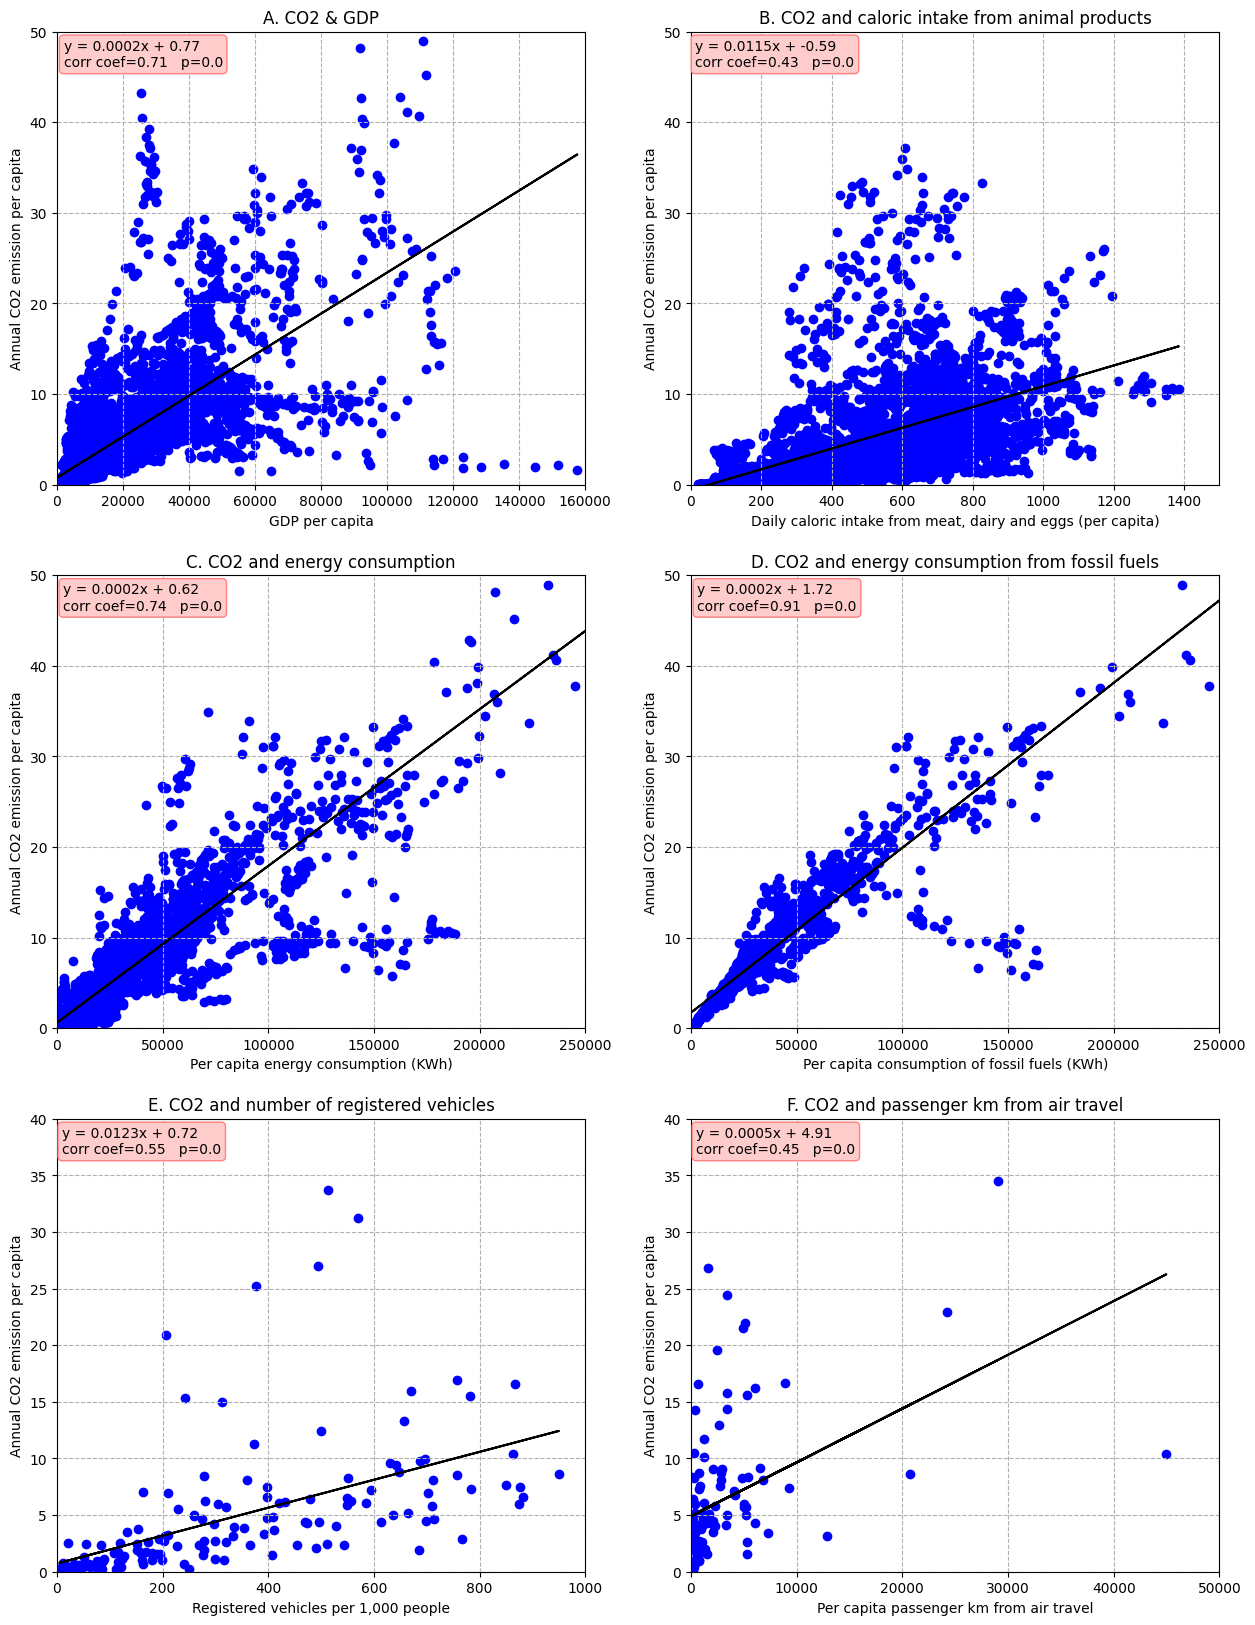

In [23]:
# Perform linear regression. Create one scatter plot for each factor included in the analysis and fit linear regression line.
fig, ((ax1, ax2), (ax3, ax4),(ax5, ax6)) = plt.subplots(3,2, figsize=(15,20))
create_scatterplot(ax1, df, column2 = 'CO2_emission', column1 = 'GDP', pos2 = 47.5, pos1 = 2000, y_lim = 50, x_lim = 160000, x_label = 'GDP per capita', title = 'A. CO2 & GDP')
create_scatterplot(ax2, df, column2 = 'CO2_emission', column1 = 'Animal_products', pos2 = 47.5, pos1 = 12.5, y_lim = 50, x_lim = 1500, x_label = 'Daily caloric intake from meat, dairy and eggs (per capita)', title = 'B. CO2 and caloric intake from animal products')
create_scatterplot(ax3, df, column2 = 'CO2_emission', column1 = 'Energy_consumption', pos2 = 47.5, pos1 = 3000, y_lim = 50, x_lim = 250000, x_label = 'Per capita energy consumption (KWh)', title = 'C. CO2 and energy consumption')
create_scatterplot(ax4, df, column2 = 'CO2_emission', column1 = 'Fossil_fuels', pos2 = 47.5, pos1 = 3000, y_lim = 50, x_lim = 250000, x_label = 'Per capita consumption of fossil fuels (KWh)', title = 'D. CO2 and energy consumption from fossil fuels')
create_scatterplot(ax5, df, column2 = 'CO2_emission', column1 = 'Vehicles', pos2 = 38, pos1 = 10, y_lim = 40, x_lim = 1000, x_label = 'Registered vehicles per 1,000 people', title = 'E. CO2 and number of registered vehicles')
create_scatterplot(ax6, df, column2 = 'CO2_emission', column1 = 'Passenger_km_air', pos2 = 38, pos1 = 500, y_lim = 40, x_lim = 50000, x_label = 'Per capita passenger km from air travel', title = 'F. CO2 and passenger km from air travel' )

# 2. Biggest strides in decreasing CO2 output

You'll need to find the relative CO2 output for each country to be able to calculate this. But countries can have growing and shrinking populations too, so it's probably a good idea to take this into account as well.

In [24]:
# read in data and discard data from before 1998.
df2 = pd.read_csv("https://raw.githubusercontent.com/ErinvanBuel/Final_Assignment/main/co-emissions-per-capita.csv")
df2.drop(columns = "Code", inplace=True)
df2 = df2[df2['Year']>=1998]
df2.rename(columns = {'Annual CO₂ emissions (per capita)':'CO2', 'Entity':'Country'}, inplace=True)
display(df2)

Country  Year       CO2
49     Afghanistan  1998  0.069134
50     Afghanistan  1999  0.056671
51     Afghanistan  2000  0.053581
52     Afghanistan  2001  0.054300
53     Afghanistan  2002  0.063856
...            ...   ...       ...
26595     Zimbabwe  2018  0.711830
26596     Zimbabwe  2019  0.636645
26597     Zimbabwe  2020  0.500945
26598     Zimbabwe  2021  0.524972
26599     Zimbabwe  2022  0.542628

[5769 rows x 3 columns]

In [25]:
find_non_default_missing_values(df2, 'Country', str) # found no non-default missing values



********************************************************************************
Finding non default missing values for column "Country"
********************************************************************************
Column "Country" has datatype: object


----------------------------------------
A: Looking at unique values
----------------------------------------
More than 200 unique values (total: 231)


----------------------------------------
B: Sorting and looking at the edges
----------------------------------------
Unique values sorted, head and tail:


['Afghanistan',
 'Africa',
 'Albania',
 'Algeria',
 'Andorra',
 'Angola',
 'Anguilla',
 'Antigua and Barbuda',
 'Argentina',
 'Armenia']

['Uruguay',
 'Uzbekistan',
 'Vanuatu',
 'Venezuela',
 'Vietnam',
 'Wallis and Futuna',
 'World',
 'Yemen',
 'Zambia',
 'Zimbabwe']



----------------------------------------
C: Casting to type: <class 'str'>
----------------------------------------
Casting to <class 'str'> was successful


----------------------------------------
D: Looking at frequency
----------------------------------------


Afghanistan      25
Nepal            25
New Caledonia    25
New Zealand      25
Nicaragua        25
                 ..
Georgia          25
Germany          25
Ghana            25
Zimbabwe         25
Kosovo           19
Name: Country, Length: 231, dtype: int64

In [26]:
find_non_default_missing_values(df2, 'Year', int) # found no non-default missing values



********************************************************************************
Finding non default missing values for column "Year"
********************************************************************************
Column "Year" has datatype: int64


----------------------------------------
A: Looking at unique values
----------------------------------------
Less than 200 unique values:
Values are sorted


[1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2020,
 2021,
 2022]



----------------------------------------
B: Sorting and looking at the edges
----------------------------------------
Unique values sorted, head and tail:


[1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007]

[2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]



----------------------------------------
C: Casting to type: <class 'int'>
----------------------------------------
Casting to <class 'int'> was successful


----------------------------------------
D: Looking at frequency
----------------------------------------


2010    231
2011    231
2021    231
2020    231
2019    231
2018    231
2017    231
2016    231
2015    231
2014    231
2013    231
2012    231
2022    231
2009    231
2008    231
2007    231
2006    231
2005    231
2004    231
1999    230
2003    230
2002    230
2001    230
2000    230
1998    230
Name: Year, dtype: int64

In [27]:
find_non_default_missing_values(df2, 'CO2', float) # CO2 emission of 0 is unlikely, replace with np.nan



********************************************************************************
Finding non default missing values for column "CO2"
********************************************************************************
Column "CO2" has datatype: float64


----------------------------------------
A: Looking at unique values
----------------------------------------
More than 200 unique values (total: 5766)


----------------------------------------
B: Sorting and looking at the edges
----------------------------------------
Unique values sorted, head and tail:


[0.019352028,
 0.020827003,
 0.02349795,
 0.02392209,
 0.024414271,
 0.025228942,
 0.025365615,
 0.025960153,
 0.027786804,
 0.031430498]

[48.970154,
 56.026558,
 58.745068,
 59.102165,
 60.826984,
 62.141323,
 62.41147,
 63.18985,
 63.489567,
 67.493744]



----------------------------------------
C: Casting to type: <class 'float'>
----------------------------------------
Casting to <class 'float'> was successful


----------------------------------------
D: Looking at frequency
----------------------------------------


3.997818     2
1.010666     2
2.059198     2
10.459453    1
5.534975     1
            ..
8.291232     1
8.106902     1
8.598022     1
8.063938     1
0.542628     1
Name: CO2, Length: 5766, dtype: int64

In [28]:
replace_value(df2, 'CO2', 0, np.nan)
df.dropna(inplace=True)
df2

Country  Year       CO2
49     Afghanistan  1998  0.069134
50     Afghanistan  1999  0.056671
51     Afghanistan  2000  0.053581
52     Afghanistan  2001  0.054300
53     Afghanistan  2002  0.063856
...            ...   ...       ...
26595     Zimbabwe  2018  0.711830
26596     Zimbabwe  2019  0.636645
26597     Zimbabwe  2020  0.500945
26598     Zimbabwe  2021  0.524972
26599     Zimbabwe  2022  0.542628

[5769 rows x 3 columns]

In [29]:
# Create dataframe containing CO2 emission data, with the country as the index and one column for each year
df3 = df2.pivot_table(index='Country', columns = 'Year', values = 'CO2')
df3

Year                   1998      1999      2000      2001      2002      2003  \
Country                                                                         
Afghanistan        0.069134  0.056671  0.053581  0.054300  0.063856  0.068871   
Africa             1.171670  1.127536  1.137337  1.097020  1.046475  1.122038   
Albania            0.542886  0.930782  0.950629  1.021259  1.200002  1.391370   
Algeria            3.560159  3.013539  2.774968  2.783221  2.867771  2.950492   
Andorra            7.529845  7.810583  7.924738  7.723235  7.496755  7.235916   
...                     ...       ...       ...       ...       ...       ...   
Wallis and Futuna  1.514780  1.754669  1.739083  1.724583  1.708500  1.703168   
World              4.063750  4.092697  4.147293  4.120682  4.158206  4.324224   
Yemen              0.729371  0.810822  0.844145  0.892070  0.843381  0.915437   
Zambia             0.243102  0.184758  0.180375  0.185009  0.186604  0.191402   
Zimbabwe           1.223648  1.342366  1.167603  1.050184  0.992590  0.878580   

Year                   2004      2005      2006      2007  ...      2013  \
Country                                                    ...             
Afghanistan        0.052529  0.077403  0.084869  0.108091  ...  0.293283   
Africa             1.156532  1.147475  1.149224  1.151465  ...  1.111445   
Albania            1.363758  1.405185  1.302100  1.326899  ...  1.831462   
Algeria            2.821092  3.367830  3.167218  3.233580  ...  3.704843   
Andorra            7.285146  7.204559  6.803704  6.888716  ...  6.672550   
...                     ...       ...       ...       ...  ...       ...   
Wallis and Futuna  1.724235  2.011253  2.052230  2.095960  ...  1.759283   
World              4.419594  4.512246  4.608319  4.683315  ...  4.859253   
Yemen              0.963526  1.015988  1.083066  1.041036  ...  1.006537   
Zambia             0.188070  0.193910  0.186368  0.184989  ...  0.289870   
Zimbabwe           0.775325  0.875149  0.840637  0.789937  ...  0.861012   

Year                   2014      2015      2016      2017      2018      2019  \
Country                                                                         
Afghanistan        0.280299  0.290076  0.261795  0.276853  0.294876  0.293401   
Africa             1.150812  1.100332  1.101652  1.085683  1.049142  1.099294   
Albania            2.080250  1.634752  1.607732  1.838272  1.701397  1.679590   
Algeria            3.903048  4.048425  3.928713  4.013210  4.085100  4.181610   
Andorra            6.443861  6.483962  6.463239  6.300733  6.592212  6.333704   
...                     ...       ...       ...       ...       ...       ...   
Wallis and Futuna  1.782246  1.800786  2.122125  2.144302  2.166216  2.185599   
World              4.832556  4.775163  4.719525  4.740302  4.785001  4.770166   
Yemen              0.953997  0.493872  0.341850  0.322784  0.376479  0.375228   
Zambia             0.309863  0.311725  0.349736  0.396010  0.415980  0.421688   
Zimbabwe           0.862179  0.865772  0.728822  0.630165  0.711830  0.636645   

Year                   2020      2021      2022  
Country                                          
Afghanistan        0.305039  0.306317  0.295364  
Africa             0.998217  1.031171  0.994221  
Albania            1.750674  1.717741  1.743200  
Algeria            3.909925  4.079527  3.927226  
Andorra            4.808461  4.592206  4.617124  
...                     ...       ...       ...  
Wallis and Futuna  2.196079  2.296465  2.281908  
World              4.464730  4.654845  4.658219  
Yemen              0.337132  0.351344  0.337017  
Zambia             0.430287  0.444877  0.445701  
Zimbabwe           0.500945  0.524972  0.542628  

[231 rows x 25 columns]

In [30]:
# create a new dataframe containing the 5-year moving average for years 2000 to 2020
df4 = df3.rolling(5, center=True, axis=1).mean().drop(columns=[1998,1999,2022,2021]).dropna(subset=2000)

In [31]:
# add columns containing CO2 emission data relative to 2000
years = list(df4.columns)
for year in years:
  df4[f'rel{year}'] = df4[year] / df4[2000] * 100


In [32]:
# select the 10 countries with the largest decrease in CO2 emission compared to 2020
df5 = df4.sort_values(by='rel2020').iloc[0:10]
df5.drop(columns=years, inplace=True)
df5 = df5.set_axis(years, axis=1, copy=False)
df5


2000        2001        2002        2003        2004        2005  \
Country                                                                        
Aruba      100.0  118.318555  137.218238  139.334393  141.213329  143.852925   
Yemen      100.0  104.516389  108.222983  112.394159  117.030223  121.827908   
Syria      100.0   98.029488   93.980432   90.196864   88.376666   93.941463   
Venezuela  100.0   95.891133   94.185784   93.256826   94.863280   91.983185   
Macao      100.0   97.771122   97.996292   97.813898   94.468281   90.481231   
Malta      100.0  102.577301  104.020414  104.918310  103.947249  103.458257   
Denmark    100.0   99.404979   97.814658   96.527407   97.414626   96.770541   
Gabon      100.0   98.213989   96.830987   94.608476   89.445727   83.725327   
Zimbabwe   100.0   94.026224   84.209699   79.146792   75.519140   72.010836   
Curacao    100.0  126.898286  145.359017  144.805540  144.281914  148.141460   

                 2006        2007        2008        2009  ...        2011  \
Country                                                    ...               
Aruba      143.325882  141.818520  137.968863  134.190762  ...   99.033577   
Yemen      125.002235  128.662502  129.225427  124.388614  ...  116.998291   
Syria       94.155982   94.468698   94.674777   93.565395  ...   75.871669   
Venezuela   90.630820   90.360785   93.711559   93.864250  ...   98.580809   
Macao       84.070819   83.390516   75.036943   69.772352  ...   63.340965   
Malta      101.109597   98.391082   97.593923   96.411298  ...   92.197066   
Denmark     93.175518   90.680868   89.525663   83.978006  ...   75.086007   
Gabon       77.499809   72.223458   68.743594   67.115043  ...   65.361801   
Zimbabwe    67.450029   65.291191   61.943760   61.163935  ...   66.432009   
Curacao    150.589395  152.276470  144.688489  141.790893  ...  139.725466   

                 2012        2013        2014        2015        2016  \
Country                                                                 
Aruba       80.724956   64.135482   47.663435   42.838086   42.695958   
Yemen      113.106711   99.870424   86.715642   75.708718   60.415265   
Syria       67.269945   59.113112   51.633752   48.240356   48.838618   
Venezuela  100.098973   96.330243   93.630892   88.954397   78.325714   
Macao       56.001811   59.618972   62.773615   68.658564   69.976612   
Malta       89.799723   81.947192   72.161769   62.599319   55.592890   
Denmark     70.992026   65.987332   63.250051   61.241156   58.582601   
Gabon       65.485505   64.598055   63.940494   62.647912   60.135061   
Zimbabwe    70.094451   73.279550   72.123661   68.346314   65.763702   
Curacao    142.172672  156.870483  160.402535  152.623752  142.421074   

                 2017       2018       2019       2020  
Country                                                 
Aruba       42.641906  42.381605  42.010772  41.696874  
Yemen       46.366756  42.562183  42.792636  43.138138  
Syria       48.103877  46.678135  45.755778  44.159311  
Venezuela   69.219882  58.639314  50.788013  44.923492  
Macao       68.261306  60.879603  53.847131  45.608778  
Malta       49.409290  47.733406  48.193364  47.921458  
Denmark     56.136178  53.657842  51.020321  48.961059  
Gabon       56.807356  54.344526  51.848302  50.390744  
Zimbabwe    61.859280  55.543444  52.014426  50.498997  
Curacao    118.572069  90.727648  68.299184  51.963369  

[10 rows x 21 columns]

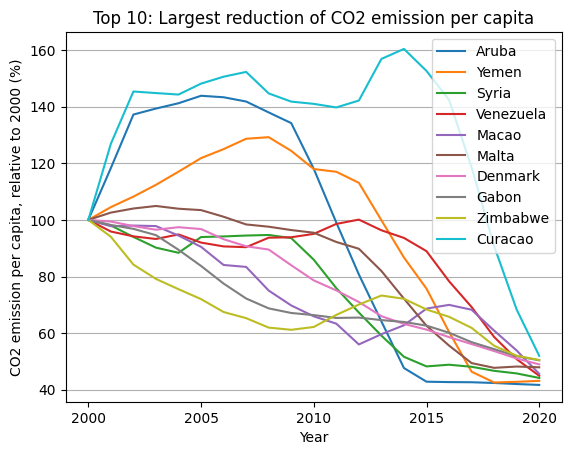

In [33]:
# Plot change in CO2 emission compared to 2000 for the top 10 countries with the largest decrease
fig, ax = plt.subplots()
ax.plot(df5.T)
ax.set_xlabel('Year')
ax.set_ylabel('CO2 emission per capita, relative to 2000 (%)')
ax.set_title('Top 10: Largest reduction of CO2 emission per capita')
ax.set_xticks(df5.columns, labels = df5.columns)
ax.locator_params(axis='x', nbins=5)
ax.legend(df5.index)
ax.grid(axis='y')

# 3. Best future price for non-fossil fuel energy

In [34]:
# Read in data and rename columns
df6 = pd.read_csv('https://raw.githubusercontent.com/ErinvanBuel/Final_Assignment/main/levelized-cost-of-energy.csv')
df6.drop(columns = "Code", inplace=True)
df6.rename(columns = {'Bioenergy levelized cost of energy':'Bioenergy',
                      'Geothermal levelized cost of energy': 'Geothermal',
                      'Offshore wind levelized cost of energy': 'Offshore_wind',
                      'Solar photovoltaic levelized cost of energy': 'Solar_photovoltaic',
                      'Concentrated solar power levelized cost of energy':'Concentrated_solar',
                      'Hydropower levelized cost of energy': 'Hydropower',
                      'Onshore wind levelized cost of energy': 'Onshore_wind',
                      'Entity':'Country'}, inplace=True)
display(df6)

Country  Year  Bioenergy  Geothermal  Offshore_wind  \
0    Argentina  2012        NaN         NaN            NaN   
1    Argentina  2013        NaN         NaN            NaN   
2    Argentina  2014        NaN         NaN            NaN   
3    Argentina  2015        NaN         NaN            NaN   
4    Argentina  2017        NaN         NaN            NaN   
..         ...   ...        ...         ...            ...   
704      World  1995        NaN         NaN            NaN   
705      World  1996        NaN         NaN            NaN   
706      World  1997        NaN         NaN            NaN   
707      World  1998        NaN         NaN            NaN   
708      World  1999        NaN         NaN            NaN   

     Solar_photovoltaic  Concentrated_solar  Hydropower  Onshore_wind  
0                   NaN                 NaN         NaN      0.117167  
1                   NaN                 NaN         NaN      0.118271  
2                   NaN                 NaN         NaN      0.103164  
3                   NaN                 NaN         NaN      0.098663  
4                   NaN                 NaN         NaN      0.103911  
..                  ...                 ...         ...           ...  
704                 NaN                 NaN         NaN      0.219476  
705                 NaN                 NaN         NaN      0.196082  
706                 NaN                 NaN         NaN      0.171793  
707                 NaN                 NaN         NaN      0.160972  
708                 NaN                 NaN         NaN      0.158667  

[709 rows x 9 columns]

In [35]:
# select only data for the world as a whole, discard data for specific countries
df7 = df6.copy().loc[df6.copy()['Country']=='World']


In [36]:
# drop column country and set the year as the index. Sort by year.
df7.drop(columns = 'Country', inplace=True)
df7.set_index('Year', inplace=True)
df7.sort_index(inplace=True)

In [37]:
df7

Bioenergy  Geothermal  Offshore_wind  Solar_photovoltaic  \
Year                                                             
1984        NaN         NaN            NaN                 NaN   
1985        NaN         NaN            NaN                 NaN   
1986        NaN         NaN            NaN                 NaN   
1987        NaN         NaN            NaN                 NaN   
1988        NaN         NaN            NaN                 NaN   
1989        NaN         NaN            NaN                 NaN   
1990        NaN         NaN            NaN                 NaN   
1991        NaN         NaN            NaN                 NaN   
1992        NaN         NaN            NaN                 NaN   
1993        NaN         NaN            NaN                 NaN   
1994        NaN         NaN            NaN                 NaN   
1995        NaN         NaN            NaN                 NaN   
1996        NaN         NaN            NaN                 NaN   
1997        NaN         NaN            NaN                 NaN   
1998        NaN         NaN            NaN                 NaN   
1999        NaN         NaN            NaN                 NaN   
2000        NaN         NaN       0.177132                 NaN   
2001        NaN         NaN       0.167386                 NaN   
2002        NaN         NaN       0.141406                 NaN   
2003        NaN         NaN       0.130749                 NaN   
2004        NaN         NaN       0.185357                 NaN   
2005        NaN         NaN       0.156486                 NaN   
2006        NaN         NaN       0.154009                 NaN   
2007        NaN    0.052497       0.224028                 NaN   
2008        NaN    0.058315       0.221206                 NaN   
2009        NaN    0.079375       0.203922                 NaN   
2010   0.082115    0.052968       0.197266               0.445   
2011   0.078753         NaN       0.206095               0.332   
2012   0.067661    0.088407       0.174729               0.248   
2013   0.086412    0.064723       0.148688               0.191   
2014   0.086581    0.066333       0.181632               0.172   
2015   0.076327    0.061978       0.148289               0.129   
2016   0.074623    0.071487       0.122831               0.113   
2017   0.074508    0.074787       0.112199               0.089   
2018   0.057697    0.068872       0.105692               0.075   
2019   0.067484    0.071406       0.091183               0.066   
2020   0.076009    0.060013       0.088097               0.059   
2021   0.070519    0.071727       0.078844               0.051   
2022   0.061469    0.063849       0.080651               0.049   

      Concentrated_solar  Hydropower  Onshore_wind  
Year                                                
1984                 NaN         NaN      0.339407  
1985                 NaN         NaN      0.315155  
1986                 NaN         NaN      0.279865  
1987                 NaN         NaN      0.271556  
1988                 NaN         NaN      0.224154  
1989                 NaN         NaN      0.207401  
1990                 NaN         NaN      0.220471  
1991                 NaN         NaN      0.211528  
1992                 NaN         NaN      0.211910  
1993                 NaN         NaN      0.222956  
1994                 NaN         NaN      0.209772  
1995                 NaN         NaN      0.219476  
1996                 NaN         NaN      0.196082  
1997                 NaN         NaN      0.171793  
1998                 NaN         NaN      0.160972  
1999                 NaN         NaN      0.158667  
2000                 NaN         NaN      0.169965  
2001                 NaN         NaN      0.149195  
2002                 NaN         NaN      0.137924  
2003                 NaN         NaN      0.120838  
2004                 NaN         NaN      0.122719  
2005                 NaN         NaN      0.114964  
2006                 NaN   

In [38]:
# for missing values, interpolate value based on the values of the previous and the next year
df7.interpolate(method='linear', inplace=True)

In [39]:
# To check whether exponential or linear regression fits the data best, determine r2 for both situations
for column in df7.columns:
  determine_r2(column, df = df7)

Bioenergy
R_square_linear = 0.3641531556377948
R_square_exponential = 0.35868203932099973 

Geothermal
R_square_linear = 0.030133890730073554
R_square_exponential = 0.02152511199625806 

Offshore_wind
R_square_linear = 0.40673061563746093
R_square_exponential = 0.30314757279143156 

Solar_photovoltaic
R_square_linear = 0.817210763735615
R_square_exponential = 0.9535390964254293 

Concentrated_solar
R_square_linear = 0.8656048478967068
R_square_exponential = 0.8404314685510617 

Hydropower
R_square_linear = 0.5092101058627454
R_square_exponential = 0.5166386757456622 

Onshore_wind
R_square_linear = 0.9423274570901659
R_square_exponential = 0.9469015593429352 



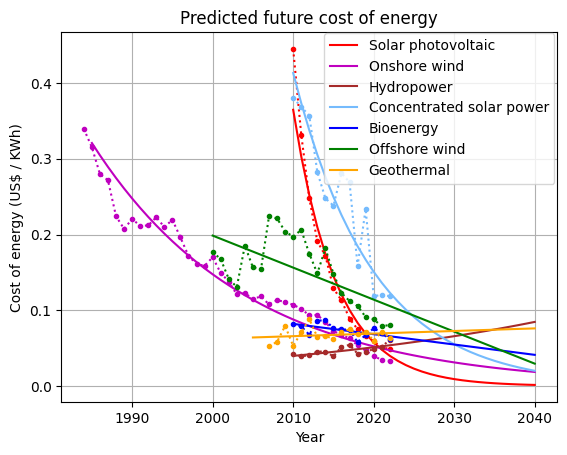

In [40]:
# plot energy cost data and fitted regression line (exponential or linear regression, whichever fits the data best based on the r2)
# although for concentrated solar power the r2 for linear regression if marginally higher than for exponential regression, prices would be reaching 0 within several years
# since in reality it is likely that prices will decrease less rapidly when approaching 0, exponential regression was chosen over linear regression
fig, ax = plt.subplots()
plot_exponential_regression(df = df7, column='Solar_photovoltaic', color='r', label='Solar photovoltaic', start=2010)
plot_exponential_regression(df = df7, column='Onshore_wind', color='m', label='Onshore wind')
plot_exponential_regression(df = df7, column='Hydropower', color='brown', label='Hydropower', start=2010)
plot_exponential_regression(df = df7, column='Concentrated_solar', color='xkcd:sky blue', label='Concentrated solar power', start=2010)
plot_linear_regression(df = df7, column='Bioenergy', color='b', label='Bioenergy', start=2010)
plot_linear_regression(df = df7, column='Offshore_wind', color='g', label='Offshore wind', start=2000)
plot_linear_regression(df = df7, column='Geothermal', color='orange', label='Geothermal', start=2005)
ax.legend(loc=(0.53,0.59))
ax.set_ylabel('Cost of energy (US$ / KWh)')
ax.set_xlabel('Year')
ax.set_title('Predicted future cost of energy')
ax.grid()
